In [28]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from operator import attrgetter
import seaborn as sns

In [29]:
# data import

customers_df = pd.read_csv('data/olist_customers_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')

In [30]:
# converting orders_df fields to date format
orders_df[['order_purchase_timestamp',
           'order_approved_at',
           'order_delivered_carrier_date',
           'order_delivered_customer_date',
           'order_estimated_delivery_date']] = orders_df[['order_purchase_timestamp',
                                                          'order_approved_at',
                                                          'order_delivered_carrier_date',
                                                          'order_delivered_customer_date',
                                                          'order_estimated_delivery_date']].apply(pd.to_datetime)

In [31]:
# converting order_items_df fields to date format
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

In [32]:
# copies of dataframes just in case
customers_copy_df = customers_df.copy()
orders_copy_df = orders_df.copy()
order_items_copy_df = order_items_df.copy()

## **Creating matrices for cohort analysis**

In [33]:
# To determine conversion to checkout, it's best to use the delivered status in order_items_df,
# since statuses are dynamic, and this status also indicates the successful purchase right up to the final stage
cohort_analysis_df = orders_copy_df.query('order_status == "delivered"')

In [34]:
# create a field with the year and month of purchase via assign to avoid SettingWithCopyWarning
cohort_analysis_df = cohort_analysis_df.assign(order_month=lambda x: x['order_purchase_timestamp'].dt.to_period('M'))

In [35]:
# merge unique user IDs to orders
cohort_analysis_customer_df = cohort_analysis_df.merge(
    customers_df[['customer_id', 'customer_unique_id']], 
    on='customer_id',
    how='left'
)

In [36]:
# copy the data to avoid changes in the converted dataframe
cohort_analysis_copy_df = cohort_analysis_customer_df.copy()

In [37]:
# extract the order day
cohort_analysis_copy_df['order_period_day'] = cohort_analysis_copy_df['order_purchase_timestamp'].dt.to_period('D')

In [38]:
# assign cohorts based on the date of first action for each customer
cohort_analysis_copy_df['cohort'] = cohort_analysis_copy_df \
    .groupby('customer_unique_id')['order_purchase_timestamp'] \
    .transform('min') \
    .dt.to_period('M')

cohort_analysis_copy_df['cohort_day'] = cohort_analysis_copy_df \
    .groupby('customer_unique_id')['order_purchase_timestamp'] \
    .transform('min') \
    .dt.to_period('D') 

In [39]:
# calculate the period number in days (monthly periods, divided by 30)
cohort_analysis_copy_df['period_number_month'] = np.floor((cohort_analysis_copy_df['order_period_day'] - cohort_analysis_copy_df['cohort_day']).apply(attrgetter('n')) / 30)

In [40]:
# aggregate data by cohort and calculated period number (in months)
df_cohort = cohort_analysis_copy_df.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

In [41]:
# create a summary for cohort analysis
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [42]:
cohort_pivot

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2503.0,7.0,13.0,11.0,3.0,2.0,9.0,4.0,6.0,6.0,...,4.0,4.0,3.0,7.0,2.0,3.0,2.0,NaN,NaN,NaN
2017-04,2256.0,8.0,6.0,1.0,6.0,8.0,6.0,10.0,5.0,6.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3451.0,14.0,14.0,8.0,13.0,11.0,11.0,4.0,10.0,9.0,...,11.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3037.0,13.0,15.0,11.0,5.0,16.0,9.0,6.0,4.0,10.0,...,9.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# calculate the median number of new clients per month

new_clients_median = cohort_pivot[0].median()
print(f"Median number of new clients per month: {new_clients_median:.0f}")

Median number of new clients per month: 4057


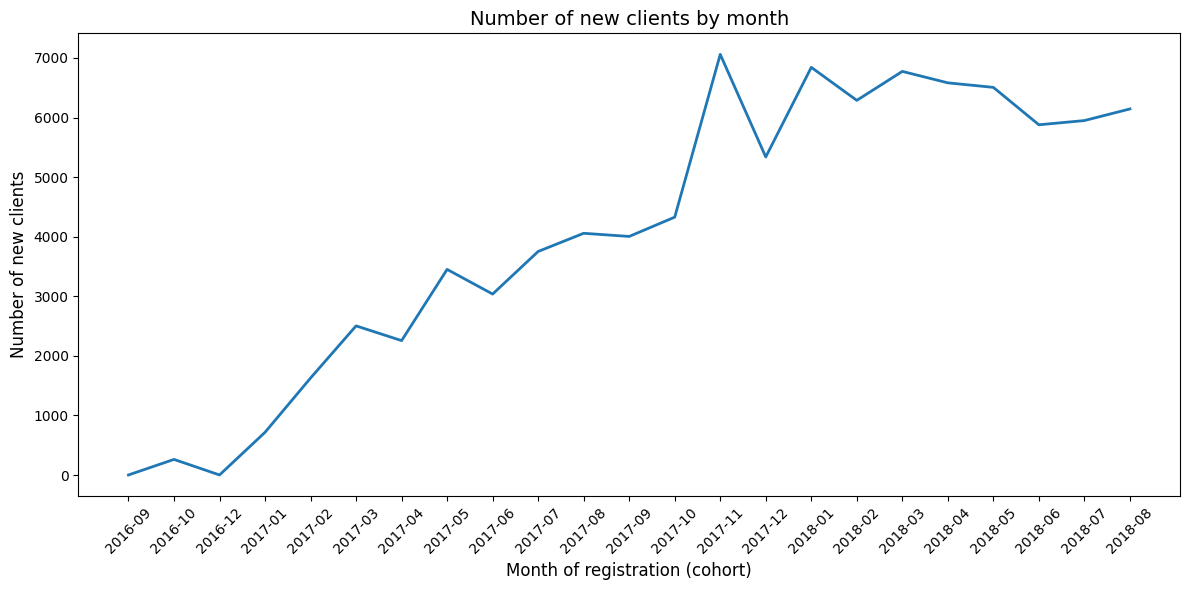

In [44]:
# Let's see how consistently they come in

# We'll calculate the months and number of new clients
cohorts = cohort_pivot.index.astype(str)
new_clients = cohort_pivot[0]

plt.figure(figsize=(12, 6))
sns.lineplot(x=cohorts, y=new_clients, linestyle='-', linewidth=2)

# Signatures and design
plt.title("Number of new clients by month", fontsize=14)
plt.xlabel("Month of registration (cohort)", fontsize=12)
plt.ylabel("Number of new clients", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [45]:
# calculate the sizes of the cohorts (first column of the table)
cohort_size = cohort_pivot.iloc[:, 0]

In [46]:
# calculate retention rates (divide those remaining by cohort by the size of their cohort)
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [47]:
retention_matrix

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN
2017-03,1.0,0.002797,0.005194,0.004395,0.001199,0.000799,0.003596,0.001598,0.002397,0.002397,...,0.001598,0.001598,0.001199,0.002797,0.000799,0.001199,0.000799,NaN,NaN,NaN
2017-04,1.0,0.003546,0.002660,0.000443,0.002660,0.003546,0.002660,0.004433,0.002216,0.002660,...,0.001330,NaN,0.000887,0.000887,0.000887,0.000887,NaN,NaN,NaN,NaN
2017-05,1.0,0.004057,0.004057,0.002318,0.003767,0.003187,0.003187,0.001159,0.002898,0.002608,...,0.003187,0.001739,0.000869,0.002028,0.001159,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.004281,0.004939,0.003622,0.001646,0.005268,0.002963,0.001976,0.001317,0.003293,...,0.002963,0.000988,0.002963,0.001317,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# average median retention for the first month
average_retention_first_month = retention_matrix[1].median()
average_retention_first_month.round(4)
print(f"Median first month retention: {average_retention_first_month:f}")

Median first month retention: 0.003546


In [49]:
# average median retention for the second month
average_retention_first_month = retention_matrix[2].median()
average_retention_first_month.round(4)
print(f"Median retention for the second month: {average_retention_first_month:f}")

Median retention for the second month: 0.002691


## Conclusion

The cohort analysis shows that a substantial number of new customers enter the product each month, with a median value of 4,057 customers. This steady inflow indicates that the marketplace is capable of attracting users who are willing to make purchases.

However, despite strong customer acquisition, only 0.3% of customers (median) remain active in the first month after their initial purchase, and this figure drops significantly in the second month.

Overall, the current retention data suggests a **weak product/market fit**. While the consistent inflow of new customers is a positive signal, the extremely low retention rate indicates the need for significant improvements in the product strategy and customer experience.